In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
data = pd.read_csv('../data/interim/data_cleaned.csv')

# Gender Analysis

In [3]:
# Calculate the percentage distribution
gender_counts = data['gender'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

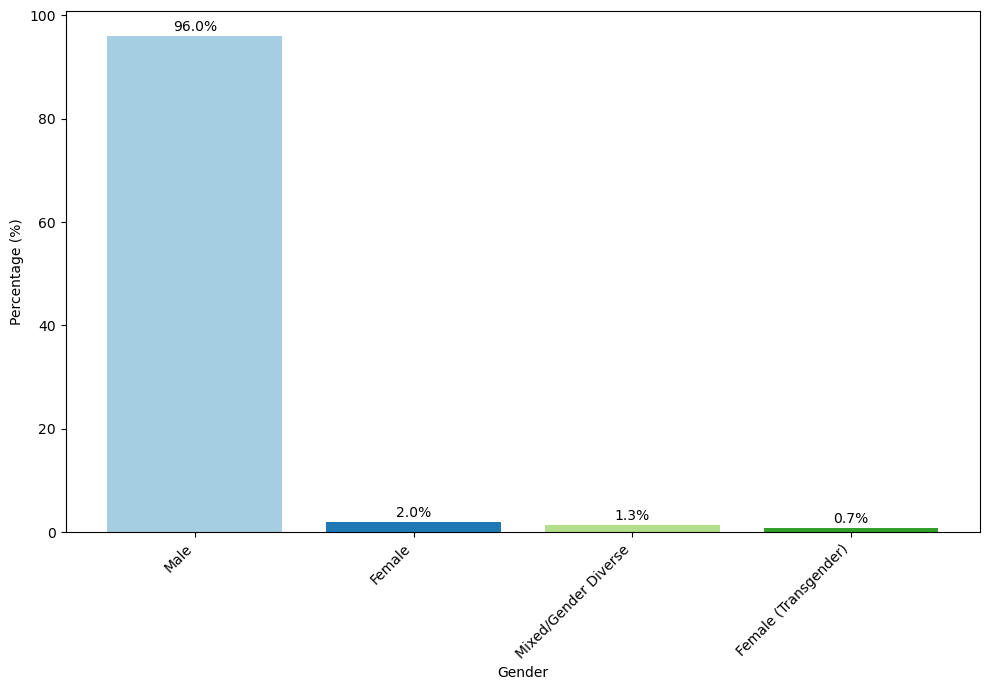

In [4]:
# Plot the percentage distribution as a bar chart
plt.figure(figsize=(10, 7))
plt.bar(gender_percentages.index, gender_percentages, color=plt.cm.Paired(range(len(gender_percentages))))
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
# plt.title('Gender Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
for i, value in enumerate(gender_percentages):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center')  # Add percentage labels above the bars
plt.tight_layout()
plt.show()

# Correlation Analysis of Numerical Features

c:\Users\Max_G\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


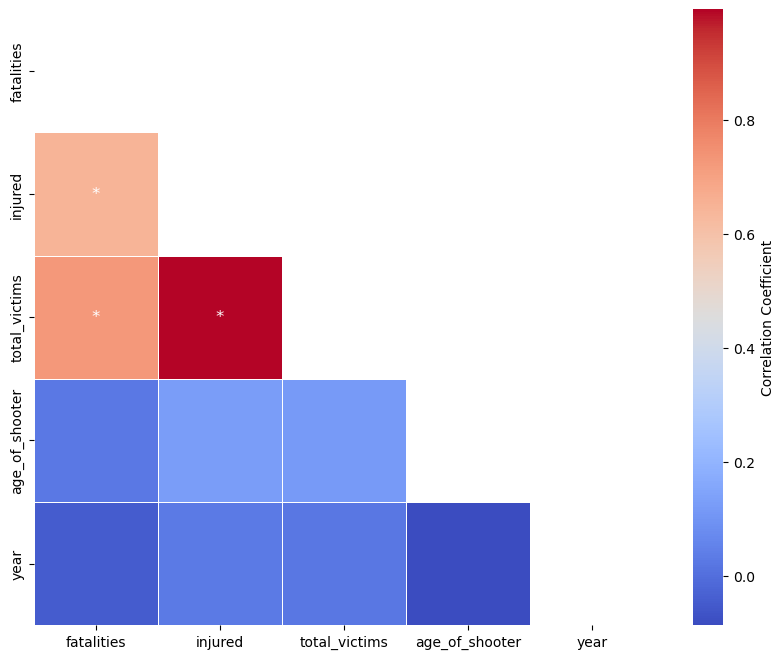

In [5]:
# Extract numerical columns from the dataset
numerical_data = data.select_dtypes(include=[np.number])
numerical_data = numerical_data.drop(columns=["latitude", "longitude"])

# Function to compute correlation and p-values
def correlation_with_pvalues(df):
    df = df.dropna()._get_numeric_data()
    cols = df.columns
    mat = np.zeros((len(cols), len(cols)), dtype=float)
    pvals = np.zeros((len(cols), len(cols)), dtype=float)
    
    for i in range(len(cols)):
        for j in range(len(cols)):
            if i == j:
                mat[i, j] = 1.0
                pvals[i, j] = 0.0
            else:
                mat[i, j], pvals[i, j] = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
                
    return pd.DataFrame(mat, index=cols, columns=cols), pd.DataFrame(pvals, index=cols, columns=cols)

# Calculate the correlation and p-value matrices
correlation_matrix_numerical, pvalue_matrix = correlation_with_pvalues(numerical_data)

# Significance level
alpha = 0.05

# Plot the heatmap for correlation matrix of numerical variables with significance
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix_numerical, dtype=bool))
sns.heatmap(correlation_matrix_numerical, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, 
            cbar_kws={'label': 'Correlation Coefficient'}, 
            annot_kws={"size": 10},
            linewidths=.5)

# Adding significance level indicator
for i in range(len(correlation_matrix_numerical.columns)):
    for j in range(len(correlation_matrix_numerical.columns)):
        if i != j:
            if pvalue_matrix.iloc[i, j] < alpha:
                plt.text(j + 0.5, i + 0.5, '*', 
                         ha='center', va='center', color='white', fontsize=12)

# plt.title('Correlation Matrix Heatmap for Numerical Variables with Significance')
plt.show()

# Mean Analysis

In [6]:
data.dropna()._get_numeric_data().mean()

fatalities           8.032258
injured             11.741935
total_victims       19.774194
age_of_shooter      33.975806
latitude            37.347759
longitude          -96.827339
year              2008.782258
dtype: float64

# Prevalence Anaylsis

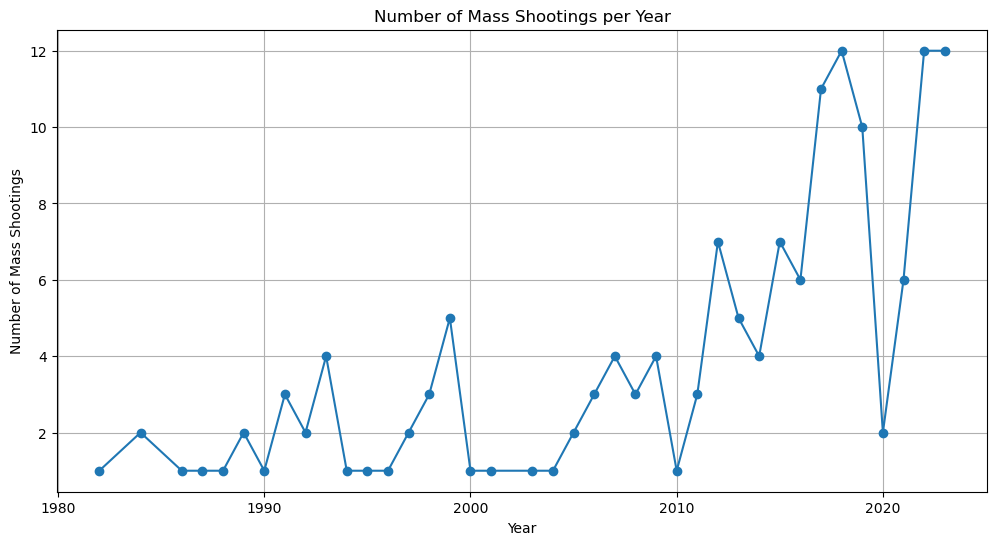

In [7]:
# Time Series Plot: Number of mass shootings per year
shootings_per_year = data['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(shootings_per_year.index, shootings_per_year.values, marker='o')
plt.title('Number of Mass Shootings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Mass Shootings')
plt.grid(True)
plt.show()


In [8]:
shootings_per_year_df = shootings_per_year.reset_index()
shootings_per_year_df.columns = ['year', 'count'] 
shootings_per_year_df['year_squared'] = shootings_per_year_df['year'] ** 2

In [9]:
# Poisson regression with formula
poisson_model = sm.GLM.from_formula('count ~ year', shootings_per_year_df, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                   39
Model:                            GLM   Df Residuals:                       37
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74.911
Date:                Mon, 19 Aug 2024   Deviance:                       36.809
Time:                        12:07:16   Pearson chi2:                     35.4
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8116
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -120.4046     16.292     -7.390      0.0

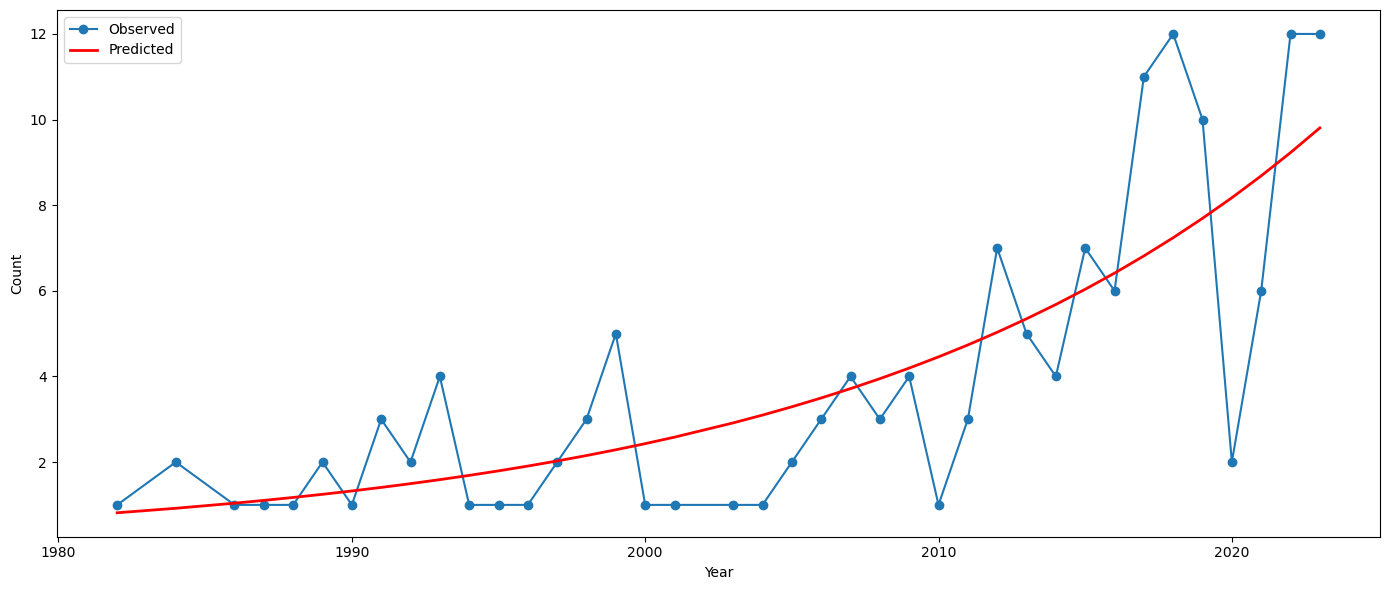

In [10]:
# Generate predictions
shootings_per_year_df['predicted'] = poisson_model.fittedvalues

# Sort values by year for plotting
sorted_df = shootings_per_year_df.sort_values(by='year')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(shootings_per_year.index, shootings_per_year.values, marker='o', label='Observed')  # Label for observed values
plt.plot(sorted_df['year'], sorted_df['predicted'], color='red', label='Predicted', linewidth=2)  # Line plot for predicted values
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

To interpret this in terms of rate ratios, you can exponentiate the coefficient: exp(0.0606) ≈ 1.0625. This means that for each additional year, the expected count increases by a factor of approximately 1.0625, or by about 6.25%.

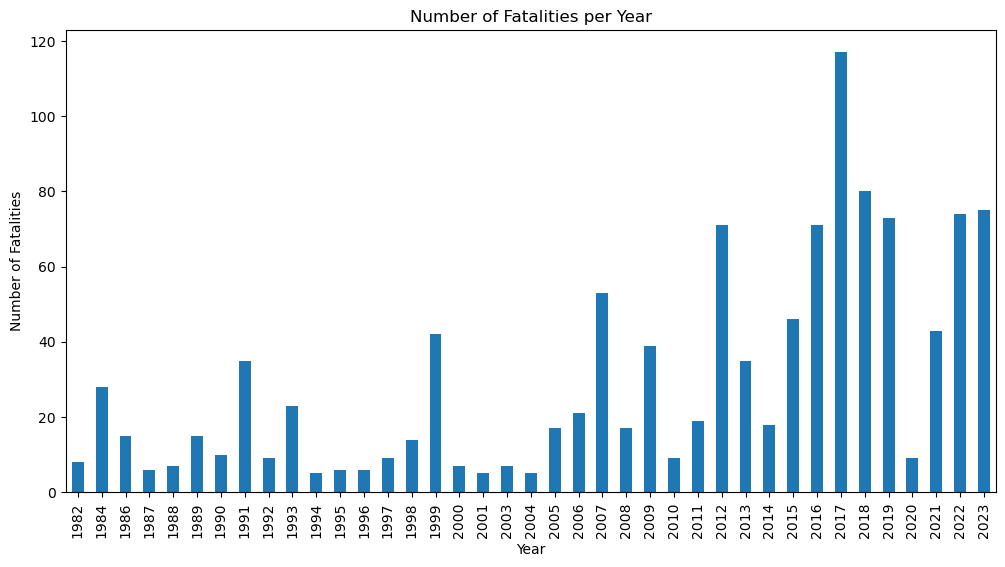

In [11]:
# Bar Plot: Number of fatalities per year
fatalities_per_year = data.groupby('year')['fatalities'].sum()
plt.figure(figsize=(12, 6))
fatalities_per_year.plot(kind='bar')
plt.title('Number of Fatalities per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fatalities')
plt.show()

# Location Analysis

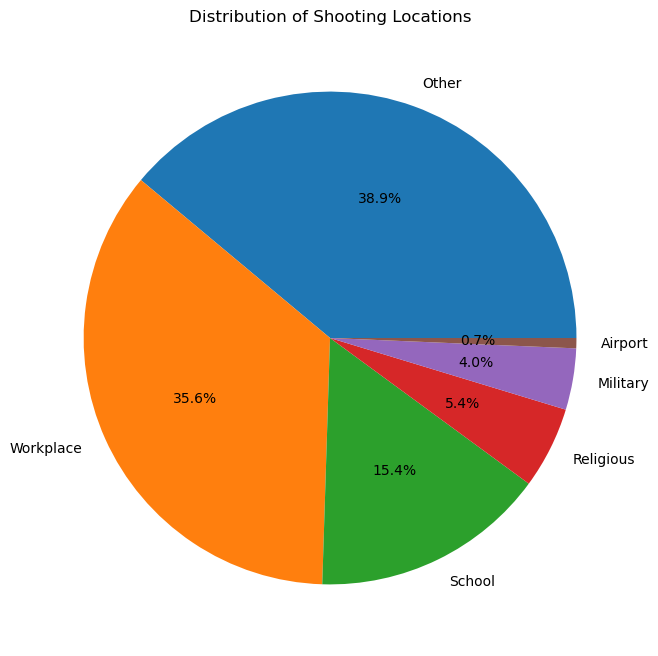

In [12]:
# Pie Chart: Distribution of the type of locations where shootings occurred
location_distribution = data['location.1'].value_counts()
plt.figure(figsize=(10, 8))
location_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Shooting Locations')
plt.ylabel('')
plt.show()

# Ethnicity Analysis

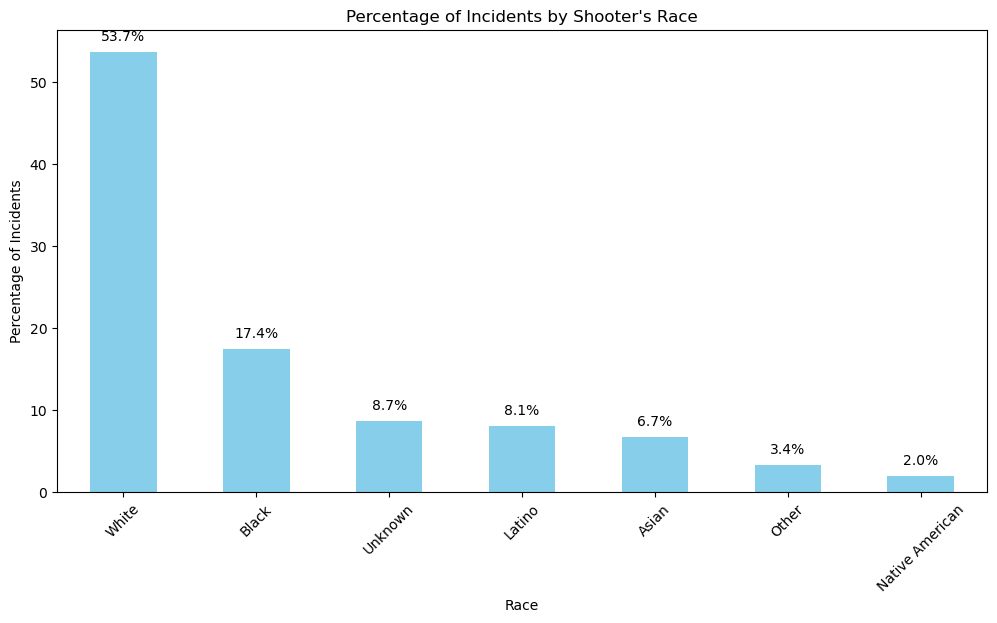

In [13]:
# Bar Plot: Number of incidents by the shooter's race
race_distribution = data['race'].value_counts()
# Calculate the percentage distribution
race_percentage = (race_distribution / race_distribution.sum()) * 100

# Plot the percentage distribution
plt.figure(figsize=(12, 6))

# Add annotations
for i, (value, percentage) in enumerate(zip(race_distribution, race_percentage)):
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
race_percentage.plot(kind='bar', color='skyblue')

plt.title("Percentage of Incidents by Shooter's Race")
plt.xlabel('Race')
plt.ylabel('Percentage of Incidents')
plt.xticks(rotation=45)
plt.show()

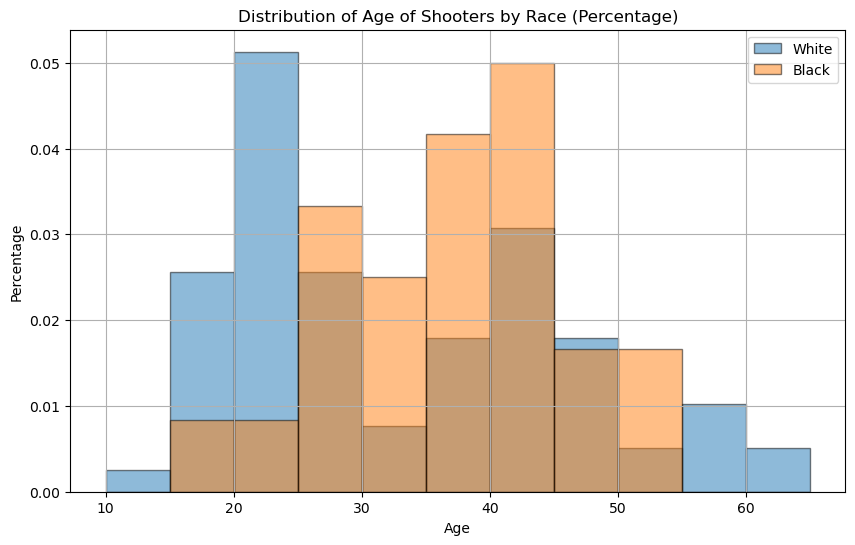

In [14]:
# Create subsets for White and Black races
data_white = data.query("race == 'White'")
data_black = data.query("race == 'Black'")
data_asian = data.query("race == 'Asian'")

# Convert the 'age_of_shooter' column to numeric, coercing errors to NaN
data['age_of_shooter'] = pd.to_numeric(data['age_of_shooter'], errors='coerce')

# Define the bin edges from 10 to 70 with 5-unit intervals
bins = range(10, 70, 5)

# Create the histogram
plt.figure(figsize=(10, 6))

# Plot histogram for White shooters
counts_white, bins_white, _ = plt.hist(data_white['age_of_shooter'], bins=bins, alpha=0.5, density=True, label='White', edgecolor='black')
counts_white = counts_white / counts_white.sum() * 100

# Plot histogram for Black shooters
counts_black, bins_black, _ = plt.hist(data_black['age_of_shooter'], bins=bins, alpha=0.5, density=True, label='Black', edgecolor='black')
counts_black = counts_black / counts_black.sum() * 100

# Calculate bar positions
bar_width = bins[1] - bins[0]
bar_positions_white = bins_white[:-1]  # Use bin edges directly for bar positions
bar_positions_black = bins_black[:-1]  # Use bin edges directly for bar positions

# Add title and labels
plt.title('Distribution of Age of Shooters by Race (Percentage)')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()


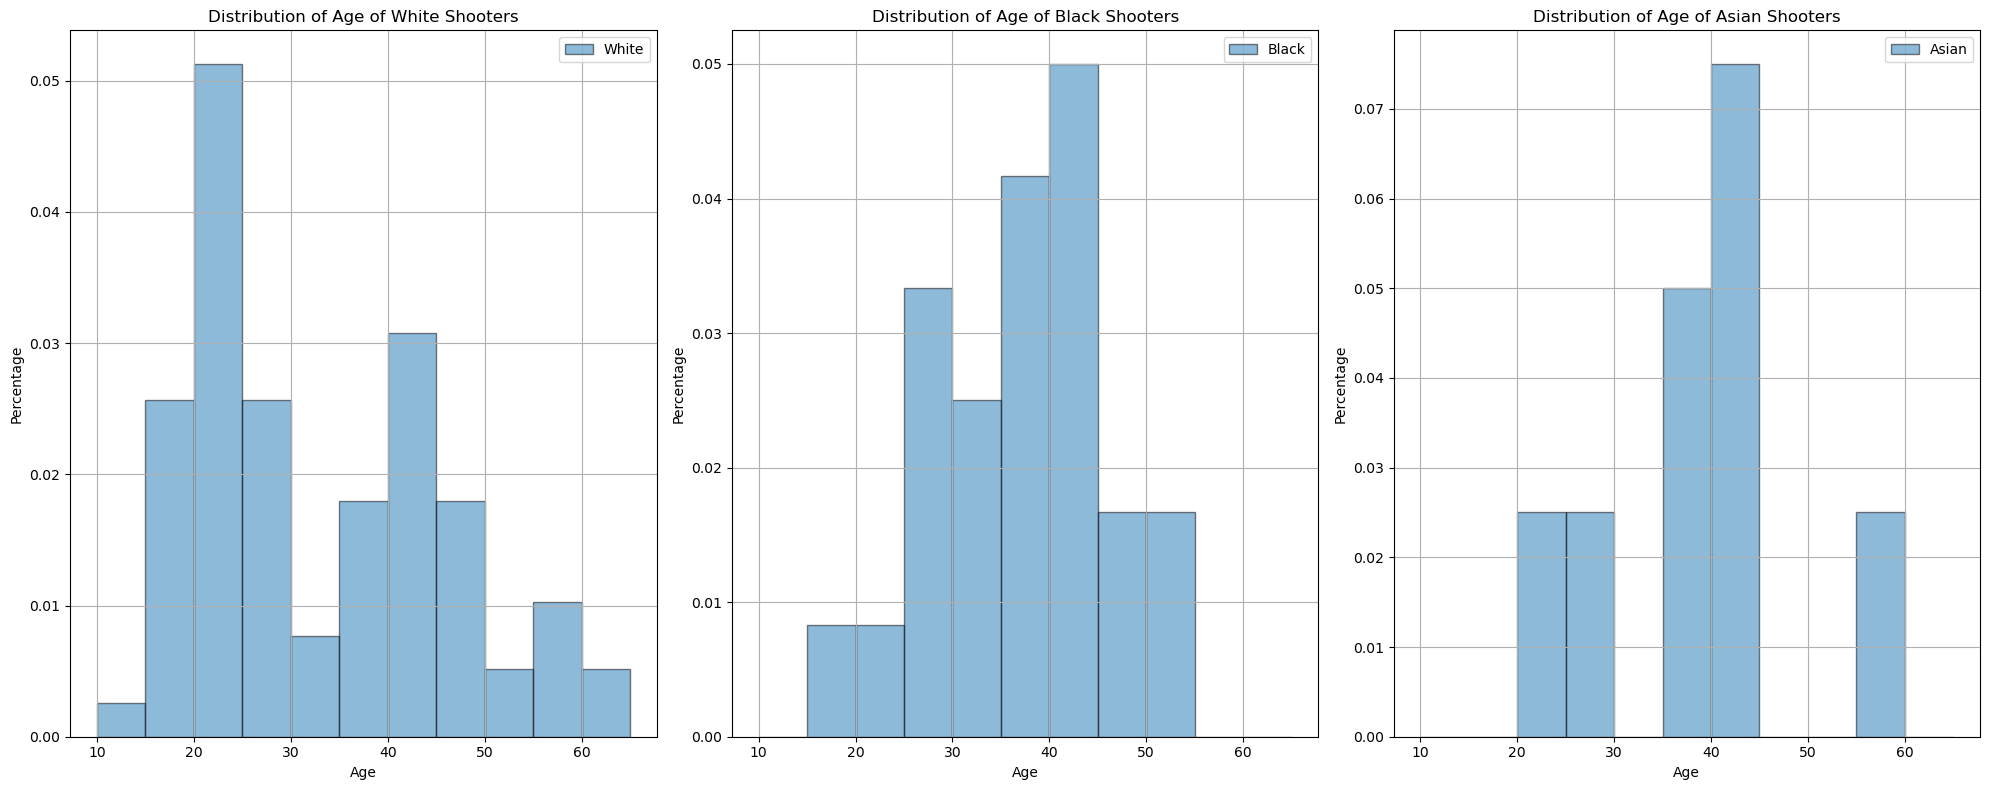

In [15]:

# Create the histogram for White and Black shooters
plt.figure(figsize=(20, 8))
# Plot histogram for White shooters
plt.subplot(1, 3, 1)
counts_white, bins_white, _ = plt.hist(data_white['age_of_shooter'], bins=bins, alpha=0.5, density=True, label='White', edgecolor='black')
counts_white = counts_white / counts_white.sum() * 100
plt.title('Distribution of Age of White Shooters')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()

# Plot histogram for Black shooters
plt.subplot(1, 3, 2)
counts_black, bins_black, _ = plt.hist(data_black['age_of_shooter'], bins=bins, alpha=0.5, density=True, label='Black', edgecolor='black')
counts_black = counts_black / counts_black.sum() * 100
plt.title('Distribution of Age of Black Shooters')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()


# Plot histogram for Asian shooters
plt.subplot(1, 3, 3)
counts_asian, bins_asian, _ = plt.hist(data_asian['age_of_shooter'], bins=bins, alpha=0.5, density=True, label='Asian', edgecolor='black')
counts_asian = counts_asian / counts_asian.sum() * 100
plt.title('Distribution of Age of Asian Shooters')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()



# Show combined plots
plt.tight_layout()
plt.show()

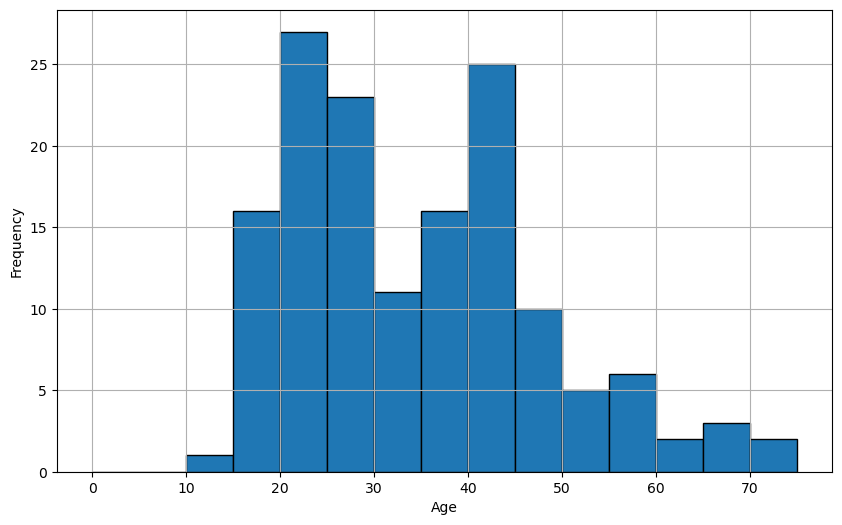

In [16]:
# Assuming data is your DataFrame
data['age_of_shooter'] = pd.to_numeric(data['age_of_shooter'], errors='coerce')

# Define bin edges explicitly
bins = list(range(0, 80, 5))  # Adjust range and step as needed

# Create a histogram with custom bins
plt.figure(figsize=(10, 6))
plt.hist(data['age_of_shooter'].dropna(), bins=bins, edgecolor='black')  # Drop NaN values for histogram
# plt.title('Distribution of Age of Shooters')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Location by Ethnicity

In [17]:
data_combined = pd.concat([data_white, data_black], ignore_index=True)

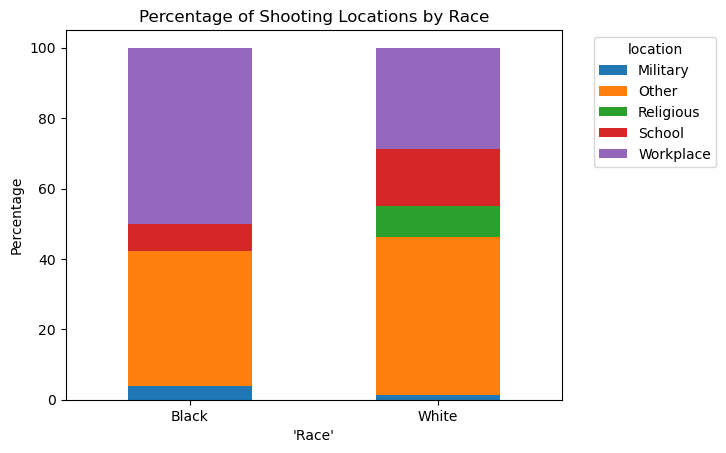

In [18]:
# Grouping the data by 'race' and 'location'
grouped_data = pd.crosstab(data_combined.race , data_combined['location.1'] )

# Calculating percentages
grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plotting
grouped_data_percentage.plot(kind='bar', stacked=True)
plt.title('Percentage of Shooting Locations by Race')
plt.xlabel("'Race'")
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Mental Health by Ethnicity

In [19]:
index_40_45_white = data.query('40 <= age_of_shooter < 45 and race == "White"').index

In [20]:
data_white.prior_signs_mental_health_issues[index_40_45_white].value_counts()/sum(data_white.prior_signs_mental_health_issues[index_40_45_white].value_counts())

prior_signs_mental_health_issues
Yes        0.833333
Unknown    0.166667
Name: count, dtype: float64

In [21]:
data_white.prior_signs_mental_health_issues.value_counts()/len(data_white)

prior_signs_mental_health_issues
Yes        0.5625
Unknown    0.3250
No         0.1125
Name: count, dtype: float64

In [22]:
data_black.prior_signs_mental_health_issues.value_counts()/len(data_black)

prior_signs_mental_health_issues
Unknown    0.500000
Yes        0.269231
No         0.230769
Name: count, dtype: float64

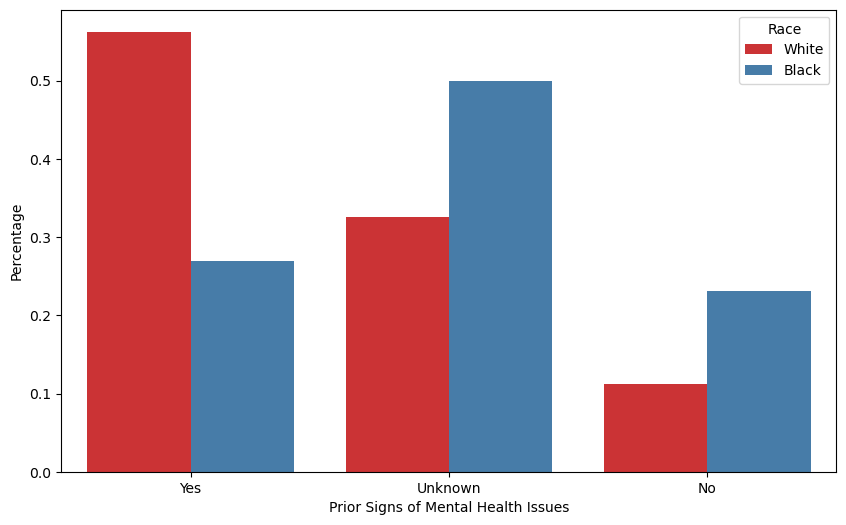

In [23]:
# Define the data for white and black datasets
data_shootings = {
    'prior_signs_mental_health_issues': ['Yes', 'Unknown', 'No'],
    'White': [0.5625, 0.3250, 0.1125],
    'Black': [0.269231, 0.500000, 0.230769]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data_shootings)

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='prior_signs_mental_health_issues', 
                    var_name='Race', 
                    value_name='Percentage')

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x='prior_signs_mental_health_issues', 
            y='Percentage', 
            hue='Race', 
            data=df_melted, 
            palette='Set1')

# Set labels and title
plt.xlabel('Prior Signs of Mental Health Issues')
plt.ylabel('Percentage')
# plt.title('Distribution of Prior Signs of Mental Health Issues by Race')
plt.legend(title='Race')

# Show the plot
plt.show()

In [24]:
data.query('40 <= age_of_shooter < 45 and race == "White"').loc[data.query('40 <= age_of_shooter < 45 and race == "White"').index].prior_signs_mental_health_issues

1          Yes
54     Unknown
62         Yes
89         Yes
91         Yes
94         Yes
111        Yes
113        Yes
117        Yes
121        Yes
145    Unknown
146        Yes
Name: prior_signs_mental_health_issues, dtype: object

# Random Sampling White Shooters between 20 and 25

In [25]:
# Filter the data for shooters aged between 20 and 25 and race is White
filtered_index = data.query('20 <= age_of_shooter < 25 and race == "White"').index

# Convert Index to Series to sample
sampled_indices = pd.Series(filtered_index).sample(n=5, random_state=1).tolist()

# Display the selected indices
print(sampled_indices)


[17, 106, 36, 76, 16]


In [26]:
data.query('20 <= age_of_shooter < 25 and race == "White"').loc[16].sources

'https://apnews.com/article/indiana-mall-shooting-345348912b288dce656083b2422c2fde; https://www.washingtonpost.com/nation/2022/07/17/indiana-mall-shooting-greenwood-park/; https://www.nytimes.com/2022/07/18/us/greenwood-indiana-mall-shooting.html'

# Confidence Interval

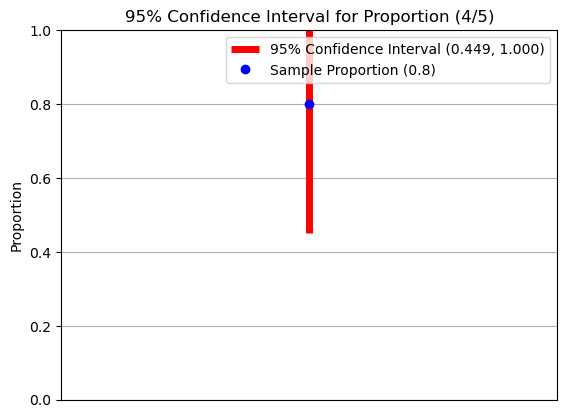

In [27]:

# Parameters
p_hat = 4 / 5
n = 5
z = 1.96  # 95% confidence level

# Calculate standard error
SE = np.sqrt(p_hat * (1 - p_hat) / n)

# Calculate margin of error
ME = z * SE

# Confidence interval
lower_bound = p_hat - ME
upper_bound = min(1, p_hat + ME)  # Adjust upper bound to 1 if it exceeds 1

fig, ax = plt.subplots()

# Plot the confidence interval
ax.vlines(0, lower_bound, upper_bound, colors='red', lw=5, label=f'95% Confidence Interval ({lower_bound:.3f}, {upper_bound:.3f})')

# Plot the sample proportion
ax.plot(0, p_hat, 'bo', label='Sample Proportion (0.8)')

# Formatting
ax.set_ylim(0, 1)
ax.set_xlim(-0.1, 0.1)
ax.set_xticks([])
ax.set_ylabel('Proportion')
ax.set_title('95% Confidence Interval for Proportion (4/5)')
ax.legend()
ax.grid(True, axis='y')

# Show plot
plt.show()
